In [ ]:
import tensorflow as tf
import numpy as np
import cv2 
import matplotlib.pyplot as plt

DIGIT_MODEL_PATH = 'digit_model.keras'
LETTER_MODEL_PATH = 'letter_model.keras'

digit_labels = {i: str(i) for i in range(10)}

letter_labels = {i: chr(ord('A') + i) for i in range(26)}

print("Library dan konfigurasi awal berhasil dimuat.")
print("Pastikan 'digit_model.keras' dan 'letter_model.keras' berada di direktori yang sama.")

Library dan konfigurasi awal berhasil dimuat.
Pastikan 'digit_model.keras' dan 'letter_model.keras' berada di direktori yang sama.


In [ ]:
try:
    digit_model = tf.keras.models.load_model(DIGIT_MODEL_PATH)
    
    letter_model = tf.keras.models.load_model(LETTER_MODEL_PATH)
    
    print("Kedua model berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat model. Pastikan nama file model benar. Error: {e}")

Kedua model berhasil dimuat.


In [ ]:
def segment_and_predict_sentence(image_path):
    """
    Memuat gambar, melakukan segmentasi karakter, dan memprediksi 
    setiap karakter menggunakan kedua model.
    """

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"ERROR: Tidak dapat memuat gambar dari path: {image_path}")
        return None

    img_inverted = cv2.bitwise_not(img)
    
    _, thresh = cv2.threshold(img_inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h > 150: 
            bounding_boxes.append((x, y, w, h))
            
    bounding_boxes.sort(key=lambda b: (b[0]))

    predicted_sentence = ""
    img_display = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    print(f"Ditemukan {len(bounding_boxes)} potensi karakter untuk dideteksi.")
    
    for (x, y, w, h) in bounding_boxes:

        char_image = img_inverted[y:y+h, x:x+w]

        max_dim = max(w, h)
        top = (max_dim - h) // 2
        bottom = max_dim - h - top
        left = (max_dim - w) // 2
        right = max_dim - w - left

        char_padded = cv2.copyMakeBorder(char_image, top + 10, bottom + 10, left + 10, right + 10, 
                                        cv2.BORDER_CONSTANT, value=0) 

        char_resized = cv2.resize(char_padded, (28, 28), interpolation=cv2.INTER_AREA)
        
        char_input = char_resized.astype('float32') / 255.0 
        char_input = char_input.reshape(1, 28, 28, 1)    

        cv2.rectangle(img_display, (x, y), (x + w, y + h), (0, 255, 0), 2) 
        
        digit_probs = digit_model.predict(char_input, verbose=0)[0]
        max_digit_prob = np.max(digit_probs)
        predicted_digit_index = np.argmax(digit_probs)
        
        letter_probs = letter_model.predict(char_input, verbose=0)[0]
        max_letter_prob = np.max(letter_probs)
        predicted_letter_index = np.argmax(letter_probs)


        if max_digit_prob > max_letter_prob:
            predicted_char = digit_labels[predicted_digit_index] 
            confidence = max_digit_prob

        elif predicted_letter_index in letter_labels:
            predicted_char = letter_labels[predicted_letter_index] 
            confidence = max_letter_prob
        
        else:
            predicted_char = '?' 
            confidence = 0
            
        predicted_sentence += predicted_char

        text_to_show = f"{predicted_char} ({confidence:.2f})"
        cv2.putText(img_display, predicted_char, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        print(f"Karakter pada box (x={x}, y={y}):")
        print(f"  > Digit Puncak: {digit_labels[predicted_digit_index]} (Conf: {max_digit_prob:.3f})")
        print(f"  > Letter Puncak: {letter_labels.get(predicted_letter_index, '?')} (Conf: {max_letter_prob:.3f})") 
        print(f"  > Pilihan Akhir: {predicted_char}")
        
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)) 
    plt.title(f"Hasil Segmentasi dan Deteksi Karakter (Total: {len(bounding_boxes)})")
    plt.axis('off')
    plt.show()
    
    return predicted_sentence

def format_sentence_with_spaces(sentence, bounding_boxes, threshold=50):
    """(Opsional) Menambahkan spasi ke hasil prediksi berdasarkan jarak antar karakter."""
    
    if not bounding_boxes:
        return sentence
    
    formatted_sentence = sentence[0]
    
    for i in range(1, len(sentence)):
        prev_x_end = bounding_boxes[i-1][0] + bounding_boxes[i-1][2]
        current_x_start = bounding_boxes[i][0]
        distance = current_x_start - prev_x_end

        if distance > threshold:
            formatted_sentence += ' '
            
        formatted_sentence += sentence[i]

    return formatted_sentence

Memulai deteksi untuk file: coba.png
Ditemukan 36 potensi karakter untuk dideteksi.
Karakter pada box (x=63, y=37):
  > Digit Puncak: 4 (Conf: 0.993)
  > Letter Puncak: A (Conf: 1.000)
  > Pilihan Akhir: A
Karakter pada box (x=64, y=155):
  > Digit Puncak: 5 (Conf: 0.497)
  > Letter Puncak: L (Conf: 0.958)
  > Pilihan Akhir: L
Karakter pada box (x=65, y=272):
  > Digit Puncak: 5 (Conf: 1.000)
  > Letter Puncak: G (Conf: 0.905)
  > Pilihan Akhir: 5
Karakter pada box (x=69, y=391):
  > Digit Puncak: 7 (Conf: 0.999)
  > Letter Puncak: R (Conf: 0.803)
  > Pilihan Akhir: 7
Karakter pada box (x=135, y=390):
  > Digit Puncak: 2 (Conf: 1.000)
  > Letter Puncak: S (Conf: 0.999)
  > Pilihan Akhir: 2
Karakter pada box (x=136, y=273):
  > Digit Puncak: 7 (Conf: 0.363)
  > Letter Puncak: T (Conf: 0.999)
  > Pilihan Akhir: T
Karakter pada box (x=138, y=155):
  > Digit Puncak: 6 (Conf: 0.999)
  > Letter Puncak: Y (Conf: 0.574)
  > Pilihan Akhir: 6
Karakter pada box (x=146, y=37):
  > Digit Puncak: 8 

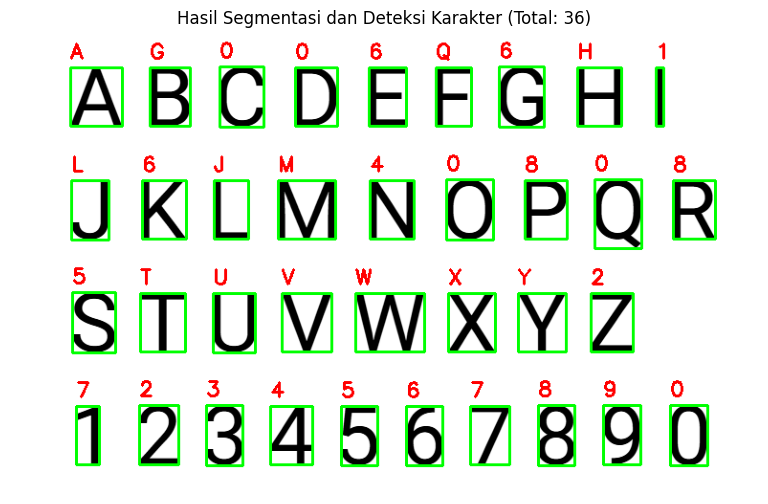


| HASIL DETEKSI KALIMAT (Tanpa Spasi Otomatis): AL572T6G3UJ04MV05W646Q0X76Y88H209108



In [ ]:
IMAGE_FILE = 'coba.png' 

print(f"Memulai deteksi untuk file: {IMAGE_FILE}")

final_result = segment_and_predict_sentence(IMAGE_FILE)

if final_result:
    print("\n" + "="*60)
    print(f"| HASIL DETEKSI KALIMAT (Tanpa Spasi Otomatis): {final_result.strip()}")
    print("="*60 + "\n")
    
    # Format spasi
    # print(f"| HASIL DETEKSI KALIMAT (Dengan Spasi Coba-coba): {format_sentence_with_spaces(final_result, segment_and_predict_sentence(IMAGE_FILE, return_boxes=True))}")
    # print("="*60)
    
else:
    print("Deteksi gagal. Silakan periksa pesan error di atas.")